<a href="https://colab.research.google.com/github/Naseungchae/Lpoint_recommendation/blob/main/CAPSTONE_PART1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CAPSTONE DESIGN_PROJECT(ongoing project)**

- **프로젝트 배경**  
: 제조공정에서 데이터 분석은 제품 생산 라인의 성능, 품질, 안정성 등을 향상시키기 위한 필수적인 과정이라고 생각합니다.  
데이터 분석을 통해 생산 라인에서 발생하는 데이터를 수집하고, 분석하여 문제를 발견하고 이를 해결하는 방안을 찾아내는 것은  
제조 과정에서 생산성과 효율성을 높이는 데 큰 역할을 할 수 있다고 생각합니다.

- **프로젝트 기간**  
: 2023-03 ~ 2023-06

- **프로젝트 진행자**  
: 201804200 나승채

- **프로젝트 목적**  
: 제조공정을 최적화하여 생산효율을 높이고 운영 비효율을 낮추는 것

- **프로젝트 세부 목표** :  
 (1) 기계 불량을 예측할 수 있는 모델 개발  
 (2) 이상치를 탐지하기 위한 모델 개발  
 (3) 다양한 접근으로 새로운 인사이트 도출  
 (4) 불균형 데이터 학습

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler

## Data description
- **index** : 고유 기기 식별자

- **product_id** : 제품 식별자
- **product_type** : 제품 유형
  - L : 낮은정도의 복잡성을 갖는 공정
  - M : 중간정도의 복잡성을 갖는 공정
  - H : 높은정도의 복잡성을 갖는 공정

- **air_temp** : 기계 주변 공기의 온도(K)

- **process_temp** : 기계 내부 고정의 온도(K)

- **r_speed** : 기계의 회전속도(rpm)  
    <i>(=회전하는 장비의 속도)</i>

- **torque** : 토크(Nm)  
    <i>(=회전하는 장비에서 발생하는 힘)</i>

- **tool_wear** : 공구의 마모 시간(m)

- **target** : 0은 고장X, 1은 고장

- **failure_type** : 고장의 경우 그 원인

In [4]:
df = pd.read_csv('/content/drive/MyDrive/capstone/dataset/predictive_maintenance.csv', index_col = 0)

df= df.rename(columns = {'Product ID' : 'product_id',
                          'Type' : 'product_type',
                          'Air temperature [K]' : 'air_temp',
                          'Process temperature [K]' : 'process_temp',
                          'Rotational speed [rpm]' : 'r_speed',
                          'Torque [Nm]' : 'torque',
                          'Tool wear [min]' : 'tool_wear',
                          'Target' : 'target',
                          'Failure Type' : 'failure_type'})

df.index.name = None


df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   product_id    10000 non-null  object 
 1   product_type  10000 non-null  object 
 2   air_temp      10000 non-null  float64
 3   process_temp  10000 non-null  float64
 4   r_speed       10000 non-null  int64  
 5   torque        10000 non-null  float64
 6   tool_wear     10000 non-null  int64  
 7   target        10000 non-null  int64  
 8   failure_type  10000 non-null  object 
dtypes: float64(3), int64(3), object(3)
memory usage: 781.2+ KB


In [5]:
df.head()

,product_id,product_type,air_temp,process_temp,r_speed,torque,tool_wear,target,failure_type
1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


## Data understanding & cleansing

In [6]:
df.isna().sum().sum()

0

In [7]:
df[['air_temp', 'process_temp', 'r_speed', 'torque', 'tool_wear']].describe()

,air_temp,process_temp,r_speed,torque,tool_wear
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,300.004930,310.005560,1538.776100,39.986910,107.951000
std,2.000259,1.483734,179.284096,9.968934,63.654147
min,295.300000,305.700000,1168.000000,3.800000,0.000000
25%,298.300000,308.800000,1423.000000,33.200000,53.000000
50%,300.100000,310.100000,1503.000000,40.100000,108.000000
75%,301.500000,311.100000,1612.000000,46.800000,162.000000
max,304.500000,313.800000,2886.000000,76.600000,253.000000


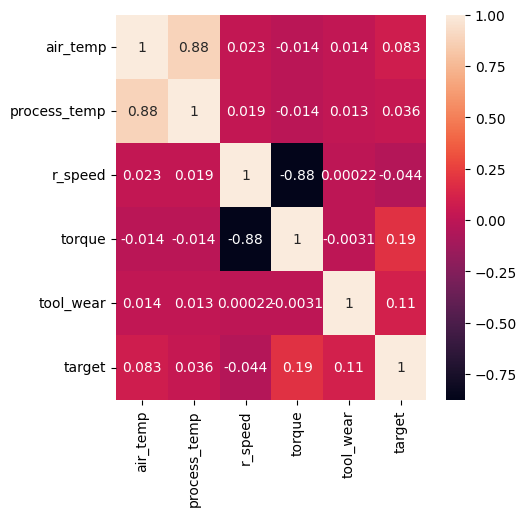

In [9]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(df.corr(), annot=True);

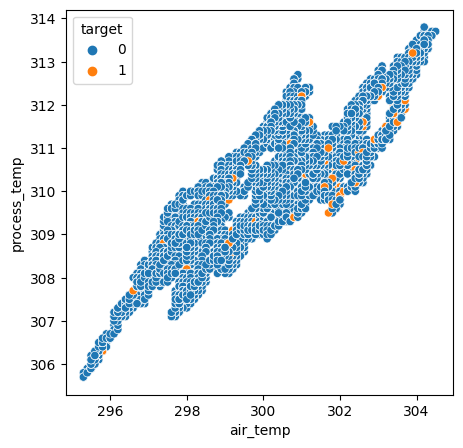

In [178]:
# air_temp, process_temp
fig, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(x='air_temp', y='process_temp', hue='target', data=df);

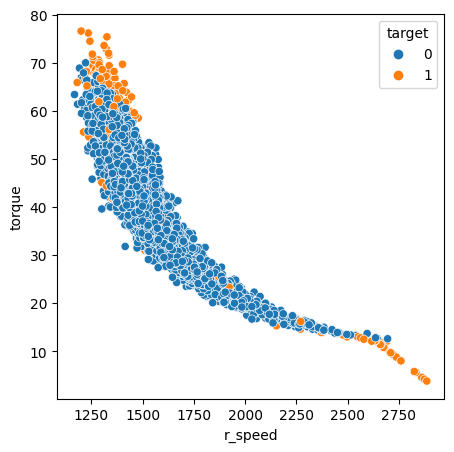

In [177]:
# r_speed, torque
fig, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(x='r_speed', y='torque', hue='target', data=df);

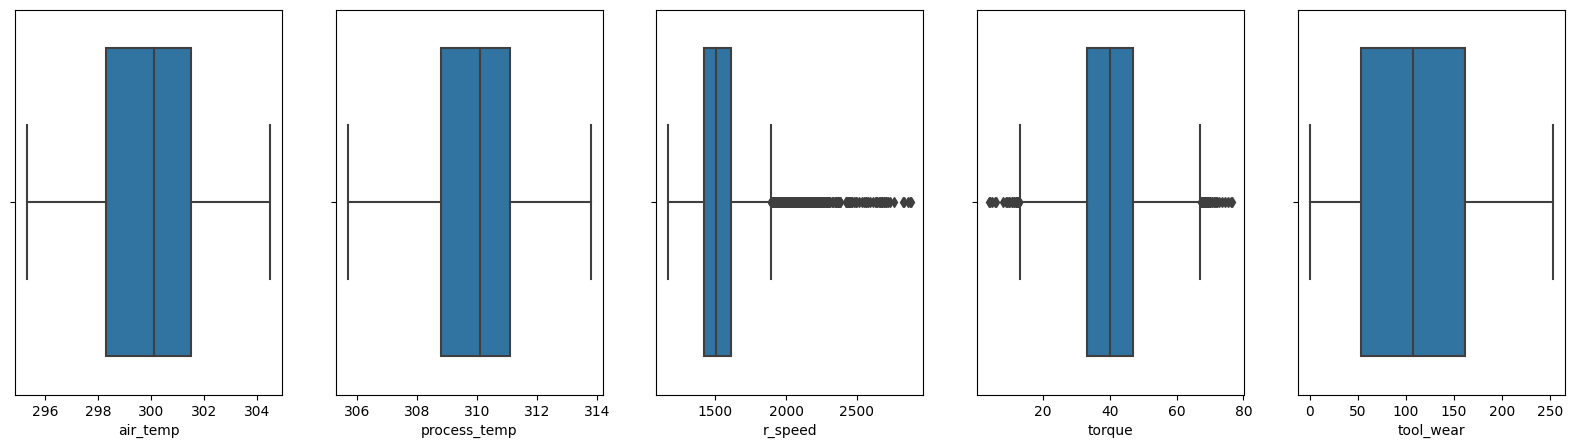

In [15]:
sub_df = df[['air_temp', 'process_temp', 'r_speed', 'torque', 'tool_wear']]

fig, axs = plt.subplots(ncols = 5, figsize = (20, 5))

for i, col in enumerate(sub_df):
    sns.boxplot(x=sub_df[col], ax=axs[i])

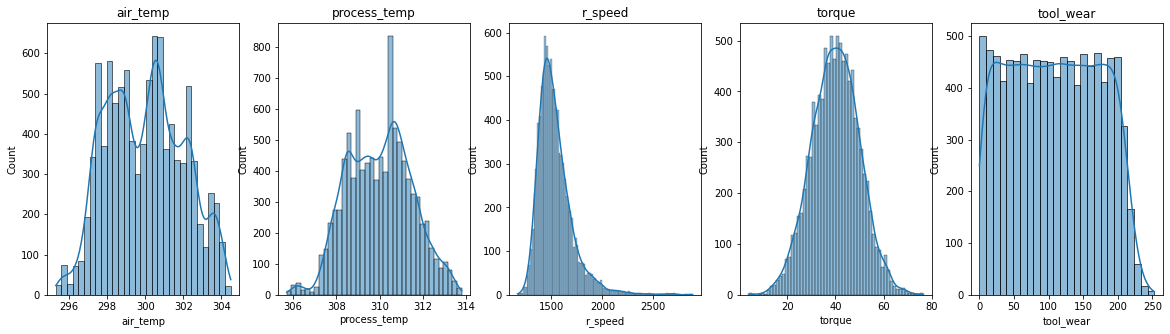

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20, 5))

for i, col in enumerate(sub_df.columns):
    sns.histplot(sub_df[col], kde=True, ax=ax[i])
    ax[i].set_title(col)

passd_product : 96.61%
not_passed_product : 3.39%



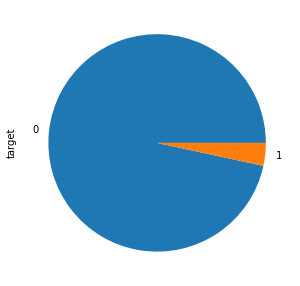

In [ ]:
faulty = []
not_faulty = []

for i in df['target'].values:
  if i == 0:
    faulty.append(i)
  else:
    not_faulty.append(i)

print(f'passd_product : {len(faulty)/df.target.count()*100}%\nnot_passed_product : {len(not_faulty)/df.target.count()*100}%\n')

fig, ax = plt.subplots(figsize=(5, 5))
df.target.value_counts().plot.pie();

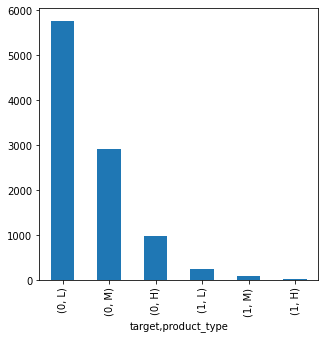

In [ ]:
# (L, 0) > (M, 0) > (H, 0) > (L, 1) > (M, 1) > (H, 1)

fig, ax = plt.subplots(figsize=(5, 5))
df.groupby('target')['product_type'].value_counts().plot.bar();

## Data preprocessing

### outlier

In [134]:
# r_speed outlier
q1_rspeed = df.r_speed.quantile(0.25)
q3_rspeed = df.r_speed.quantile(0.75)
iqr_rspeed = q3_rspeed - q1_rspeed
maximum_rspeed = q3_rspeed + (1.5 * iqr_rspeed)
minimum_rspeed = q1_rspeed - (1.5 * iqr_rspeed)
condition_rspeed = ((df['r_speed'] <= minimum_rspeed) | (df['r_speed'] >= maximum_rspeed))
print(f'r_speed minimun value : {minimum_rspeed}\nr_speed maximun value : {maximum_rspeed}')

# torque outlier
q1_torque = df.torque.quantile(0.25)
q3_torque = df.torque.quantile(0.75)
iqr_torque = q3_torque - q1_torque
maximum_torque = q3_torque + (1.5 * iqr_torque)
minimum_torque = q1_torque - (1.5 * iqr_torque)
condition_torque = ((df['torque'] <= minimum_torque) | (df['torque'] >= maximum_torque))
print(f'torque minimun value : {minimum_torque}\ntorque maximun value : {maximum_torque}')

print()

outlier_df = df[condition_rspeed & condition_torque]
outlier_df

r_speed minimun value : 1139.5
r_speed maximun value : 1895.5
torque minimun value : 12.800000000000011
torque maximun value : 67.19999999999999



,product_id,product_type,air_temp,process_temp,r_speed,torque,tool_wear,target,failure_type
51,L47230,L,298.9,309.1,2861,4.6,143,1,Power Failure
195,M15054,M,298.2,308.5,2678,10.7,86,1,Power Failure
381,L47560,L,297.5,308.3,2564,12.8,127,1,Power Failure
464,L47643,L,297.4,308.7,2874,4.2,118,1,Power Failure
848,L48027,L,296.4,307.4,2833,5.6,213,1,Power Failure
1096,L48275,L,296.9,307.5,2721,9.3,18,1,Power Failure
1392,L48571,L,298.9,310.2,2737,8.8,142,1,Power Failure
1785,L48964,L,298.3,308.0,2886,3.8,57,1,Power Failure
1809,L48988,L,298.1,307.7,2567,12.8,125,1,Power Failure
3141,H32554,H,300.4,309.9,2563,12.8,81,1,Power Failure


passd_product : 10.714285714285714%
not_passed_product : 89.28571428571429%



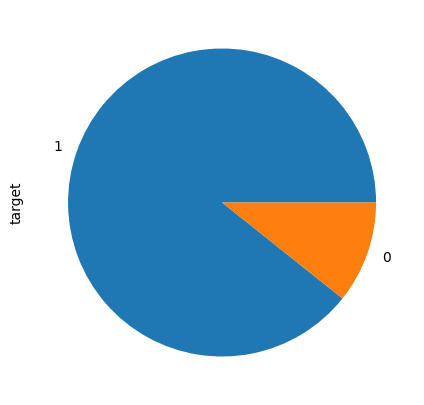

In [132]:
faulty = []
not_faulty = []

for i in outlier_df['target'].values:
  if i == 0:
    faulty.append(i)
  else:
    not_faulty.append(i)

print(f'passd_product : {len(faulty)/outlier_df.target.count()*100}%\nnot_passed_product : {len(not_faulty)/outlier_df.target.count()*100}%\n')

fig, ax = plt.subplots(figsize=(5, 5))
outlier_df.target.value_counts().plot.pie();